In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
#import a module check_ecdf from the file check_ecdf.py that is in the parent directory
import sys
sys.path.append('../')

from check_ecdf import get_empirical_cdf


ModuleNotFoundError: No module named 'numpy'

# CDF of Traces

In [3]:
# load the prediction error for gaussA gaussC step 192000 from /Users/sultandaniels/Documents/Transformer_Kalman/outputs/GPT2/240615_182401.2139c3_gaussA_gauss_C/prediction_errors_gauss_C_step=192000.ckpt/gaussA_err_lss.pkl

with open('/Users/sultandaniels/Documents/Transformer_Kalman/outputs/GPT2/240615_182401.2139c3_gaussA_gauss_C/prediction_errors_gauss_C_step=192000.ckpt/gaussA_err_lss.pkl', 'rb') as f:
    gaussA_err_lss = pickle.load(f)




odict_keys(['MOP', 'MOP_analytical', 'Zero'])


In [43]:
print(gaussA_err_lss.keys())
print(gaussA_err_lss['MOP'].shape)

sys = 1
ind = 100
samples = gaussA_err_lss['MOP'][sys,:,ind]


odict_keys(['MOP', 'MOP_analytical', 'Zero'])
(3, 2000, 251)


In [44]:
samples_ecdf = get_empirical_cdf(samples)

samples_epdf = np.gradient(samples_ecdf.y, samples_ecdf.x)

/Users/sultandaniels/.pyenv/versions/3.8.12/lib/python3.8/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/sultandaniels/.pyenv/versions/3.8.12/lib/python3.8/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))


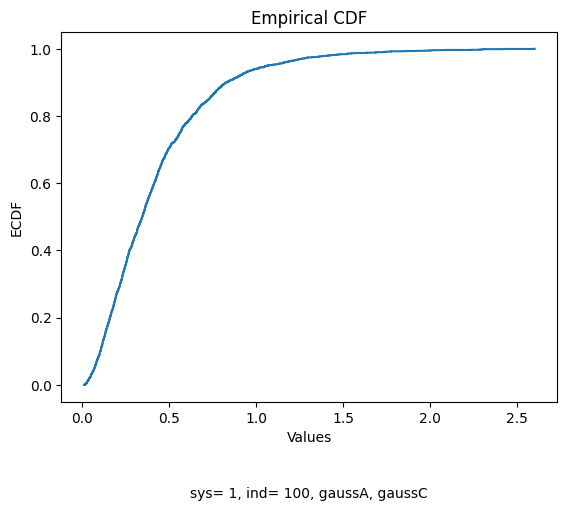

In [45]:
# Plot the empirical CDF
plt.step(samples_ecdf.x, samples_ecdf.y, where='post')
plt.xlabel('Values')
plt.ylabel('ECDF')
plt.title('Empirical CDF')
#caption the plot with the sys and ind and gaussA and gaussC
plt.text(0.5, -0.25, "sys= " + str(sys) + ", ind= " + str(ind) + ', gaussA, gaussC', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.grid(True)
plt.show()

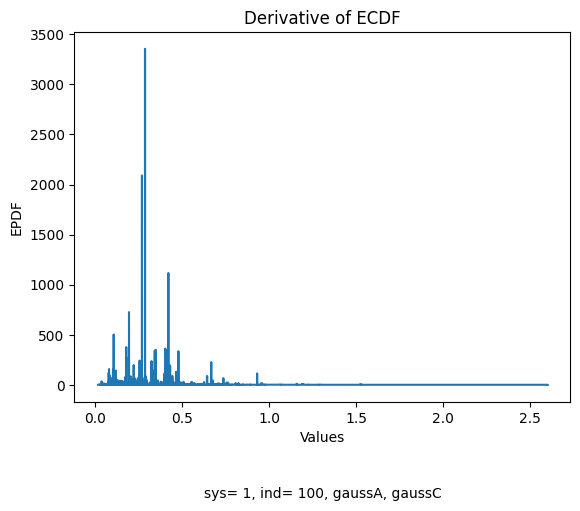

In [46]:
# Plot the empirical PDF
plt.step(samples_ecdf.x, samples_epdf, where='post')
plt.xlabel('Values')
plt.ylabel('EPDF')
plt.title('Derivative of ECDF')
plt.text(0.5, -0.25, "sys= " + str(sys) + ", ind= " + str(ind) + ', gaussA, gaussC', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.grid(True)
plt.show()


# Bootstrapping

In [47]:
sys_preds = gaussA_err_lss['MOP'][sys,:,:]
print("sys_preds shape: ", sys_preds.shape)

sys_preds shape:  (2000, 251)


In [61]:
# create a list to index the predictions for each system
sys_indices = [i for i in range(sys_preds.shape[0])]

# sample n random indices from the list with replacement
n = 2000
B = int(1e2) # number of bootstrap samples
bootstrap_indices = np.random.choice(sys_indices, (B, n), replace=True) #choose B samples of n indices with replacement
print("bootstrap_indices shape: ", bootstrap_indices.shape)

#take the median of the predictions for each bootstrap sample
medians = np.zeros((B, sys_preds.shape[1]))
for i in range(B):
    sys_preds_sample = sys_preds[bootstrap_indices[i], :]
    medians[i] = np.median(sys_preds_sample, axis=0)


bootstrap_indices shape:  (100, 2000)


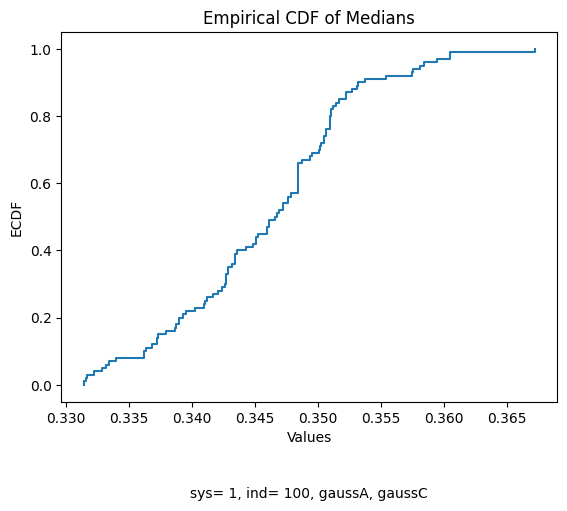

In [62]:
#get the value of the medians at ind
medians_ind = medians[:, ind]
#get the empirical CDF of the medians
medians_ecdf = get_empirical_cdf(medians_ind)
# Plot the empirical CDF of medians at ind
plt.step(medians_ecdf.x, medians_ecdf.y, where='post')
plt.xlabel('Values')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Medians')
plt.text(0.5, -0.25, "sys= " + str(sys) + ", ind= " + str(ind) + ', gaussA, gaussC', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.grid(True)
plt.show()

medians shape:  (100, 251)
median of medians shape:  (251,)
quantiles shape:  (2, 251)


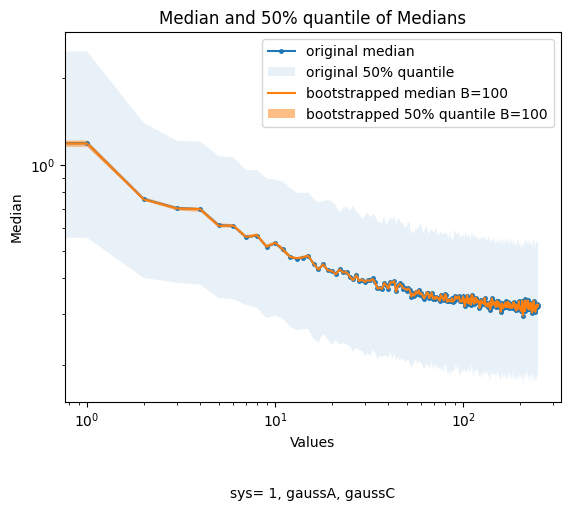

In [90]:
#get the median and quantiles of the medians
median_of_medians = np.median(medians, axis=0)
print("medians shape: ", medians.shape)
print("median of medians shape: ", median_of_medians.shape)

median_quantiles = np.quantile(medians, [0.25, 0.75], axis=0)
print("quantiles shape: ", median_quantiles.shape)

#get the original median and quantiles
original_median = np.median(sys_preds, axis=0)
original_quantiles = np.quantile(sys_preds, [0.25, 0.75], axis=0)

# Plot the original median and quantiles on the same plot
plt.plot(list(range(len(original_median))), original_median, label='original median', marker='.', markersize=5)
plt.fill_between(list(range(len(original_median))), original_quantiles[0], original_quantiles[1], alpha=0.1, label='original 50% quantile')

# Plot the median and quantiles of the medians at ind
plt.plot(list(range(len(median_of_medians))), median_of_medians, label='bootstrapped median B=' + str(B))
plt.fill_between(list(range(len(median_of_medians))), median_quantiles[0], median_quantiles[1], alpha=0.5, label='bootstrapped 50% quantile B=' + str(B))
plt.xlabel('Values')
plt.ylabel('Median')
plt.title('Median and 50% quantile of Medians')
plt.text(0.5, -0.25, "sys= " + str(sys) + ', gaussA, gaussC', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.yscale('log')
plt.xscale('log')





plt.legend()

# plt.grid(True)
plt.show()
